<a href="https://colab.research.google.com/github/z-arabi/SRU-deeplearning-workshop/blob/master/28_Autodiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Introduction to gradients and automatic differentiation

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/guide/autodiff"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/autodiff.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/guide/autodiff.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/guide/autodiff.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Automatic Differentiation and Gradients

[Automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation)
is useful for implementing machine learning algorithms such as
[backpropagation](https://en.wikipedia.org/wiki/Backpropagation) for training
neural networks.

In this guide, you will explore ways to compute gradients with TensorFlow, especially in eager execution.

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

## Computing gradients

To differentiate automatically, TensorFlow needs to remember what operations happen in what order during the *forward* pass.  Then, during the *backward pass*, TensorFlow traverses this list of operations in reverse order to compute gradients.

## Gradient tapes

TensorFlow provides the `tf.GradientTape` API for automatic differentiation; that is, computing the gradient of a computation with respect to some inputs, usually `tf.Variable`s.
TensorFlow "records" relevant operations executed inside the context of a `tf.GradientTape` onto a "tape". TensorFlow then uses that tape to compute the gradients of a "recorded" computation using [reverse mode differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation).

Here is a simple example:

In [3]:
'''
The model previously > calcaultes the gradients
Update the weights with the negative value * alpha value * gradients automatically
Now we want to take the control of this procedure
'''

'\nThe model previously > calcaultes the gradients\nUpdate the weights with the negative value * alpha value * gradients automatically\nNow we want to take the control of this procedure\n'

In [4]:
# Variable is something that we can calculate the Gradient
# all the weights and biases in the network is from Variable type
# in tensorflow there is a different between constant number and Variable number (it has tensor embedded in it)
x = tf.Variable(3.0)
print(x)

# tape is the tool to calculate the differentiations automatically
with tf.GradientTape() as tape:
  y = x**2
  print(y)

y2 = x ** 2
print(y2)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.0>
tf.Tensor(9.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)


Once you've recorded some operations, use `GradientTape.gradient(target, sources)` to calculate the gradient of some target (often a loss) relative to some source (often the model's variables):

In [5]:
# because y is defined in the tape context > you can ask about the gradient
# dy = 2x * dx
dy_dx = tape.gradient(y, x)
# the output is Tensor, ans it is number not the formula
print(dy_dx)
dy_dx.numpy()

tf.Tensor(6.0, shape=(), dtype=float32)


6.0

The above example uses scalars, but `tf.GradientTape` works as easily on any tensor:

In [6]:
w = tf.Variable(tf.random.normal((3, 2)), name='w')
print(w)
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name='b')
print(b)
x = [[1., 2., 3.]]

# We have to kill tape manually otherwise it will remain and take the memory
with tf.GradientTape(persistent=True) as tape:
  y = x @ w + b
  print(y)
  # np.mean(y**2, axis=0)
  loss = tf.reduce_mean(y**2)
  print(loss)

<tf.Variable 'w:0' shape=(3, 2) dtype=float32, numpy=
array([[ 0.08740828,  0.6415414 ],
       [ 0.46360582, -1.3661915 ],
       [-0.22604091, -1.2969147 ]], dtype=float32)>
<tf.Variable 'b:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>
tf.Tensor([[ 0.3364972 -5.9815855]], shape=(1, 2), dtype=float32)
tf.Tensor(17.946299, shape=(), dtype=float32)


To get the gradient of `loss` with respect to both variables, you can pass both as sources to the `gradient` method. The tape is flexible about how sources are passed and will accept any nested combination of lists or dictionaries and return the gradient structured the same way (see `tf.nest`).

In [7]:
[dl_dw, dl_db] = tape.gradient(loss, [w, b])
# dl/dw has the same shape of the w
[dl_dw, dl_db]

[<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[  0.3364972,  -5.9815855],
        [  0.6729944, -11.963171 ],
        [  1.0094916, -17.944756 ]], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 0.3364972, -5.9815855], dtype=float32)>]

The gradient with respect to each source has the shape of the source:

In [8]:
print(w.shape)
print(dl_dw.shape)

(3, 2)
(3, 2)


Here is the gradient calculation again, this time passing a dictionary of variables:

In [9]:
my_vars = {
    'w': w,
    'b': b
}

# A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)
# in the context manager of tape the first time that we use that it will close the context automatically
grad = tape.gradient(loss, my_vars)
grad['b']

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 0.3364972, -5.9815855], dtype=float32)>

## Gradients with respect to a model

It's common to collect `tf.Variables` into a `tf.Module` or one of its subclasses (`layers.Layer`, `keras.Model`) for [checkpointing](checkpoint.ipynb) and [exporting](saved_model.ipynb).

In most cases, you will want to calculate gradients with respect to a model's trainable variables.  Since all subclasses of `tf.Module` aggregate their variables in the `Module.trainable_variables` property, you can calculate these gradients in a few lines of code:

In [10]:
layer = tf.keras.layers.Dense(2, activation='relu')
# it is not variable > same as > x=[[1., 2., 3.]]
x = tf.constant([[1., 2., 3.]])

with tf.GradientTape() as tape:
  # Forward pass
  y = layer(x)
  loss = tf.reduce_mean(y**2)

# we have (3,2) weights in total + (2,) for biases
print(layer.trainable_variables)

# Calculate gradients with respect to every trainable variable
grad = tape.gradient(loss, layer.trainable_variables)
print(grad)

[<tf.Variable 'dense/kernel:0' shape=(3, 2) dtype=float32, numpy=
array([[-0.31976295,  0.5353756 ],
       [-0.40878272, -0.18923682],
       [ 0.91149616,  0.25204194]], dtype=float32)>, <tf.Variable 'dense/bias:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>]
[<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1.5971601 , 0.91302776],
       [3.1943202 , 1.8260555 ],
       [4.79148   , 2.7390833 ]], dtype=float32)>, <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.5971601 , 0.91302776], dtype=float32)>]


In [11]:
for var in layer.trainable_variables:
  print(f'{var.name}, shape: {var.shape}')

dense/kernel:0, shape: (3, 2)
dense/bias:0, shape: (2,)


<a id="watches"></a>

## Controlling what the tape watches

The default behavior is to record all operations after accessing a trainable `tf.Variable`. The reasons for this are:

* The tape needs to know which operations to record in the forward pass to calculate the gradients in the backwards pass.
* The tape holds references to intermediate outputs, so you don't want to record unnecessary operations.
* The most common use case involves calculating the gradient of a loss with respect to all a model's trainable variables.

For example, the following fails to calculate a gradient because the `tf.Tensor` is not "watched" by default, and the `tf.Variable` is not trainable:

In [12]:
# in the tape context > by default all the Variables are controlled and watched


# A trainable variable
x0 = tf.Variable(3.0, name='x0')
# Not trainable
x1 = tf.Variable(3.0, name='x1', trainable=False)
# Not a Variable: A variable + tensor returns a tensor.
x2 = tf.Variable(2.0, name='x2') + 1.0
# Not a variable
x3 = tf.constant(3.0, name='x3')

with tf.GradientTape() as tape:
  y = (x0**2) + (x1**2) + (x2**2)

# doesn't return error just return None
grad = tape.gradient(y, [x0, x1, x2, x3])

for g in grad:
  print(g)

tf.Tensor(6.0, shape=(), dtype=float32)
None
None
None


You can list the variables being watched by the tape using the `GradientTape.watched_variables` method:

In [15]:
[var for var in tape.watched_variables()]
[var.name for var in tape.watched_variables()]

['x0:0']

`tf.GradientTape` provides hooks that give the user control over what is or is not watched.

To record gradients with respect to a `tf.Tensor`, you need to call `GradientTape.watch(x)`:

In [16]:
x = tf.constant(3.0)
with tf.GradientTape() as tape:
  # conver a non-variable to a variable
  tape.watch(x)
  y = x**2

# dy = 2x * dx
dy_dx = tape.gradient(y, x)
print(dy_dx.numpy())

6.0


Conversely, to disable the default behavior of watching all `tf.Variables`, set `watch_accessed_variables=False` when creating the gradient tape. This calculation uses two variables, but only connects the gradient for one of the variables:

In [23]:
x0 = tf.Variable(0.0)
x1 = tf.Variable(10.0)

# as defualt it will watch all variables > made it false
with tf.GradientTape(watch_accessed_variables=False) as tape:
  tape.watch(x1)
  y0 = tf.math.sin(x0)
  y1 = tf.nn.softplus(x1)
  y = y0 + y1
  ys = tf.reduce_sum(y)

Since `GradientTape.watch` was not called on `x0`, no gradient is computed with respect to it:

In [24]:
# dys/dx1 = exp(x1) / (1 + exp(x1)) = sigmoid(x1)
grad = tape.gradient(ys, {'x0': x0, 'x1': x1, 'y': y})

print('dy/dx0:', grad['x0'])
print('dy/dx1:', grad['x1'].numpy())
print('dy/dx1:', grad['y'])

dy/dx0: None
dy/dx1: 0.9999546
dy/dx1: tf.Tensor(1.0, shape=(), dtype=float32)


## Intermediate results

You can also request gradients of the output with respect to intermediate values computed inside the `tf.GradientTape` context.

In [19]:
x = tf.constant(3.0)

with tf.GradientTape() as tape:
  tape.watch(x)
  y = x * x
  z = y * y

# Use the tape to compute the gradient of z with respect to the
# intermediate value y.
# dz_dy = 2 * y and y = x ** 2 = 9
print(tape.gradient(z, y).numpy())

18.0


By default, the resources held by a `GradientTape` are released as soon as the `GradientTape.gradient` method is called. To compute multiple gradients over the same computation, create a gradient tape with `persistent=True`. This allows multiple calls to the `gradient` method as resources are released when the tape object is garbage collected. For example:

In [25]:
x = tf.constant([1, 3.0])
with tf.GradientTape(persistent=True) as tape:
  tape.watch(x)
  y = x * x
  z = y * y

print(tape.gradient(z, x).numpy())  # [4.0, 108.0] (4 * x**3 at x = [1.0, 3.0])
print(tape.gradient(y, x).numpy())  # [2.0, 6.0] (2 * x at x = [1.0, 3.0])

[  4. 108.]
[2. 6.]


In [26]:
del tape   # Drop the reference to the tape

## Notes on performance

* There is a tiny overhead associated with doing operations inside a gradient tape context. For most eager execution this will not be a noticeable cost, but you should still use tape context around the areas only where it is required.

* Gradient tapes use memory to store intermediate results, including inputs and outputs, for use during the backwards pass.

  For efficiency, some ops (like `ReLU`) don't need to keep their intermediate results and they are pruned during the forward pass. However, if you use `persistent=True` on your tape, *nothing is discarded* and your peak memory usage will be higher.

## Gradients of non-scalar targets

A gradient is fundamentally an operation on a scalar.

In [27]:
x = tf.Variable(2.0)
with tf.GradientTape(persistent=True) as tape:
  y0 = x**2
  y1 = 1 / x

print(tape.gradient(y0, x).numpy())
print(tape.gradient(y1, x).numpy())

4.0
-0.25


Thus, if you ask for the gradient of multiple targets, the result for each source is:

* The gradient of the sum of the targets, or equivalently
* The sum of the gradients of each target.

In [28]:
x = tf.Variable(2.0)
with tf.GradientTape() as tape:
  y0 = x**2
  y1 = 1 / x

# returns the sum  of dy0/dx + dy1/dx
print(tape.gradient({'y0': y0, 'y1': y1}, x).numpy())

3.75


Similarly, if the target(s) are not scalar the gradient of the sum is calculated:

In [29]:
x = tf.Variable(2.)

with tf.GradientTape() as tape:
  y = x * [3., 4.]

# the target is a vector dy/dx = [3,4]
print(tape.gradient(y, x).numpy())

7.0


This makes it simple to take the gradient of the sum of a collection of losses, or the gradient of the sum of an element-wise loss calculation.

If you need a separate gradient for each item, refer to [Jacobians](advanced_autodiff.ipynb#jacobians).

In some cases you can skip the Jacobian. For an element-wise calculation, the gradient of the sum gives the derivative of each element with respect to its input-element, since each element is independent:

In [30]:
x = tf.linspace(-10.0, 10.0, 200+1)

with tf.GradientTape() as tape:
  tape.watch(x)
  y = tf.nn.sigmoid(x)

dy_dx = tape.gradient(y, x)

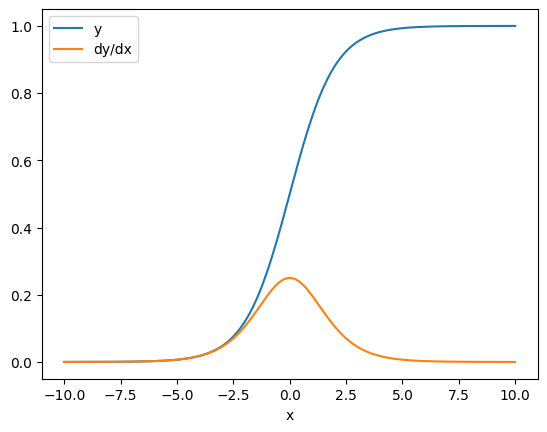

In [31]:
plt.plot(x, y, label='y')
plt.plot(x, dy_dx, label='dy/dx')
plt.legend()
_ = plt.xlabel('x')

## Control flow

Because a gradient tape records operations as they are executed, Python control flow is naturally handled (for example, `if` and `while` statements).

Here a different variable is used on each branch of an `if`. The gradient only connects to the variable that was used:

In [32]:
x = tf.constant(1.0)

v0 = tf.Variable(2.0)
v1 = tf.Variable(2.0)

with tf.GradientTape(persistent=True) as tape:
  tape.watch(x)
  if x > 0.0:
    result = v0
  else:
    result = v1**2

# we have just one of the outputs based on the x
dv0, dv1 = tape.gradient(result, [v0, v1])

print(dv0)
print(dv1)

tf.Tensor(1.0, shape=(), dtype=float32)
None


Just remember that the control statements themselves are not differentiable, so they are invisible to gradient-based optimizers.

Depending on the value of `x` in the above example, the tape either records `result = v0` or `result = v1**2`. The gradient with respect to `x` is always `None`.

In [33]:
# result is not the parameter of x
dx = tape.gradient(result, x)

print(dx)

None


## Cases where `gradient` returns `None`

When a target is not connected to a source, `gradient` will return `None`.


In [34]:
x = tf.Variable(2.)
y = tf.Variable(3.)

with tf.GradientTape() as tape:
  z = y * y
print(tape.gradient(z, x))

None


Here `z` is obviously not connected to `x`, but there are several less-obvious ways that a gradient can be disconnected.

### 1. Replaced a variable with a tensor

In the section on ["controlling what the tape watches"](#watches) you saw that the tape will automatically watch a `tf.Variable` but not a `tf.Tensor`.

One common error is to inadvertently replace a `tf.Variable` with a `tf.Tensor`, instead of using `Variable.assign` to update the `tf.Variable`. Here is an example:

In [45]:
x = tf.Variable(2.0)

for epoch in range(2):
  with tf.GradientTape() as tape:
    y = x+1

  print(type(x).__name__, ":", tape.gradient(y, x))


  x = x + 1   # This should be `x.assign_add(1)`
  # x.assign_add(1)

ResourceVariable : tf.Tensor(1.0, shape=(), dtype=float32)
EagerTensor : None


### 2. Did calculations outside of TensorFlow

The tape can't record the gradient path if the calculation exits TensorFlow.
For example:

In [56]:
x = tf.Variable([[1.0, 2.0],
                 [3.0, 4.0]], dtype=tf.float32)

with tf.GradientTape() as tape:
  x2 = x**2

  # This step is calculated with NumPy > it breaks the chain evenif we convert the output to
  # tensor ( bceuase the tape can't make the gradient of numpy arrays)
  y = np.mean(x2, axis=0)
  print(y, type(y))

  y = tf.convert_to_tensor(y, dtype=tf.float32)
  print(y)

print(tape.gradient(y, x))

[ 5. 10.] <class 'numpy.ndarray'>
tf.Tensor([ 5. 10.], shape=(2,), dtype=float32)
None


In [57]:
x = tf.Variable([[1.0, 2.0],
                 [3.0, 4.0]], dtype=tf.float32)

with tf.GradientTape() as tape:
  x2 = x**2

  # The output is tensor
  y = tf.reduce_mean(x2, axis=0)
  print(y, type(y))

print(tape.gradient(y, x))

tf.Tensor([ 5. 10.], shape=(2,), dtype=float32) <class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[[1. 2.]
 [3. 4.]], shape=(2, 2), dtype=float32)


In [58]:
x = tf.Variable([[1.0, 2.0],
                 [3.0, 4.0]], dtype=tf.float32)

with tf.GradientTape() as tape:
  x2 = x**2

  # This step is calculated with NumPy
  y = np.mean(x2, axis=0)
  print(y, type(y))

  # # Like most ops, reduce_mean will cast the NumPy array to a constant tensor
  # # using `tf.convert_to_tensor`.
  y = tf.reduce_mean(y, axis=0)
  print(type(y))

print(tape.gradient(y, x))

[ 5. 10.] <class 'numpy.ndarray'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
None


### 3. Took gradients through an integer or string

Integers and strings are not differentiable. If a calculation path uses these data types there will be no gradient.

Nobody expects strings to be differentiable, but it's easy to accidentally create an `int` constant or variable if you don't specify the `dtype`.

In [59]:
# no integer > you have to have float data type to have the gradient
x = tf.constant(10)

with tf.GradientTape() as g:
  g.watch(x)
  y = x * x

print(g.gradient(y, x))

None


In [60]:
# no integer > you have to have float data type to have the gradient
x = tf.constant(10.0)

with tf.GradientTape() as g:
  g.watch(x)
  y = x * x

print(g.gradient(y, x))

tf.Tensor(20.0, shape=(), dtype=float32)


TensorFlow doesn't automatically cast between types, so, in practice, you'll often get a type error instead of a missing gradient.

### 4. Took gradients through a stateful object

State stops gradients. When you read from a stateful object, the tape can only observe the current state, not the history that lead to it.

A `tf.Tensor` is immutable. You can't change a tensor once it's created. It has a _value_, but no _state_. All the operations discussed so far are also stateless: the output of a `tf.matmul` only depends on its inputs.

A `tf.Variable` has internal state—its value. When you use the variable, the state is read. It's normal to calculate a gradient with respect to a variable, but the variable's state blocks gradient calculations from going farther back. For example:


In [76]:
x0 = tf.Variable(3.0)
x1 = tf.Variable(5.0)
print(x1)

with tf.GradientTape() as tape:
  # Update x1 = x1 + x0.
  # A `tf.Tensor` is immutable. You can't change a tensor once it's created. It has a _value_, but no _state_.
  x1.assign_add(x0)
  print(x1, type(x1))
  # The tape starts recording from x1.
  y = x1**2   # y = (x1 + x0)**2
  print(y)

# This doesn't work.
print(tape.gradient(y, [x0, x1]))   #dy/dx0 = 2*(x1 + x0)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=5.0>
<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=8.0> <class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
tf.Tensor(64.0, shape=(), dtype=float32)
[None, <tf.Tensor: shape=(), dtype=float32, numpy=16.0>]


In [77]:
x0 = tf.Variable(3.0)
x1 = tf.Variable(0.0)

with tf.GradientTape() as tape:
  x2 = x1 + x0
  print(x2, type(x2))
  # The tape starts recording from x1.
  y = x2**2   # y = (x1 + x0)**2

# This doesn't work.
print(tape.gradient(y, [x0, x1]))   #dy/dx0 = 2*(x1 + x0)

tf.Tensor(3.0, shape=(), dtype=float32) <class 'tensorflow.python.framework.ops.EagerTensor'>
[<tf.Tensor: shape=(), dtype=float32, numpy=6.0>, <tf.Tensor: shape=(), dtype=float32, numpy=6.0>]


Similarly, `tf.data.Dataset` iterators and `tf.queue`s are stateful, and will stop all gradients on tensors that pass through them.

## No gradient registered

Some `tf.Operation`s are **registered as being non-differentiable** and will return `None`. Others have **no gradient registered**.

The `tf.raw_ops` page shows which low-level ops have gradients registered.

If you attempt to take a gradient through a float op that has no gradient registered the tape will throw an error instead of silently returning `None`. This way you know something has gone wrong.

For example, the `tf.image.adjust_contrast` function wraps `raw_ops.AdjustContrastv2`, which could have a gradient but the gradient is not implemented:


In [78]:
image = tf.Variable([[[0.5, 0.0, 0.0]]])
delta = tf.Variable(0.1)

with tf.GradientTape() as tape:
  new_image = tf.image.adjust_contrast(image, delta)
  print(new_image)

try:
  # the output doens't have the gradient
  print(tape.gradient(new_image, [image, delta]))
  assert False   # This should not happen.
except LookupError as e:
  print(f'{type(e).__name__}: {e}')


tf.Tensor([[[0.5 0.  0. ]]], shape=(1, 1, 3), dtype=float32)
LookupError: gradient registry has no entry for: AdjustContrastv2


If you need to differentiate through this op, you'll either need to implement the gradient and register it (using `tf.RegisterGradient`) or re-implement the function using other ops.

## Zeros instead of None

In some cases it would be convenient to get 0 instead of `None` for unconnected gradients.  You can decide what to return when you have unconnected gradients using the `unconnected_gradients` argument:

In [79]:
x = tf.Variable([2., 2.])
y = tf.Variable(3.)

with tf.GradientTape() as tape:
  z = y**2
print(tape.gradient(z, x, unconnected_gradients=tf.UnconnectedGradients.ZERO))

tf.Tensor([0. 0.], shape=(2,), dtype=float32)
